In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(f"Libraries imported successfully!")
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

Libraries imported successfully!
Using device: cuda
GPU: NVIDIA GeForce RTX 5090


In [2]:
ratings = pd.read_csv('../data/ml-25m/ratings.csv')
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')

split_date = '2015-01-01'
train = ratings[ratings['datetime'] < split_date].copy()
test = ratings[ratings['datetime'] >= split_date].copy()

# Normalize ratings to 0-1 scale
min_rating = 0.5
max_rating = 5.0
train['rating'] = (train['rating'] - min_rating) / (max_rating - min_rating)
test['rating'] = (test['rating'] - min_rating) / (max_rating - min_rating)

print(f"Train: {len(train):,} ratings")
print(f"Test: {len(test):,} ratings")
print(f"Rating range after normalization: {train['rating'].min():.2f} - {train['rating'].max():.2f}")

Train: 17,436,354 ratings
Test: 7,563,741 ratings
Rating range after normalization: 0.00 - 1.00


In [3]:
user_ids = train['userId'].unique()
movie_ids = train['movieId'].unique()

# Create mappings from ID to index
user_id_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_id_to_index = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

# Map onto train and test
train['user_index'] = train['userId'].map(user_id_to_index)
train['movie_index'] = train['movieId'].map(movie_id_to_index)

test['user_index'] = test['userId'].map(user_id_to_index)
test['movie_index'] = test['movieId'].map(movie_id_to_index)

n_users = len(user_ids)
n_movies = len(movie_ids)

print(f"Number of users: {n_users:,}")
print(f"Number of movies: {n_movies:,}")
print(f"Train cold start users: {train['user_index'].isna().sum()}")
print(f"Test cold start users: {test['user_index'].isna().sum():,}")

Number of users: 121,673
Number of movies: 22,316
Train cold start users: 0
Test cold start users: 6,836,326


In [4]:
class MovieRatingDataset(Dataset):
    def __init__(self, dataframe):
        valid = dataframe['user_index'].notna() & dataframe['movie_index'].notna()
        dataframe = dataframe[valid].reset_index(drop=True)
        
        self.user_indices = torch.tensor(dataframe['user_index'].values, dtype=torch.long).to(device)
        self.movie_indices = torch.tensor(dataframe['movie_index'].values, dtype=torch.long).to(device)
        self.ratings = torch.tensor(dataframe['rating'].values, dtype=torch.float32).to(device)
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.user_indices[idx], self.movie_indices[idx], self.ratings[idx]

# Create datasets
train_dataset = MovieRatingDataset(train)
test_dataset = MovieRatingDataset(test)

print(f"Train dataset size: {len(train_dataset):,}")
print(f"Test dataset size: {len(test_dataset):,}")

Train dataset size: 17,436,354
Test dataset size: 546,990


In [5]:
BATCH_SIZE = 1024

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches per epoch: {len(train_loader):,}")
print(f"Test batches: {len(test_loader):,}")

Batch size: 1024
Training batches per epoch: 17,028
Test batches: 535


In [6]:
class NCF(nn.Module):
    def __init__(self, n_users, n_movies, embedding_dim=32):
        super(NCF, self).__init__()
        
        # Embedding layers
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)
        
        # Initialize embeddings
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.movie_embedding.weight, std=0.1)
        
        # Neural network layers
        self.fc1 = nn.Linear(embedding_dim * 2, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)
        
        # ReLU and Dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, user_indices, movie_indices):
        user_vec = self.user_embedding(user_indices)
        movie_vec = self.movie_embedding(movie_indices)
        
        x = torch.cat([user_vec, movie_vec], dim=1)
        
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.fc4(x)
        
        return x.squeeze()

# Initialize model
model = NCF(n_users, n_movies, embedding_dim=32).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Model initialized on: {device}")
print(f"Total parameters: {total_params:,}")

Model initialized on: cuda
Total parameters: 4,610,401


In [7]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam([
    {'params': model.user_embedding.parameters(), 'lr': 0.005},
    {'params': model.movie_embedding.parameters(), 'lr': 0.005},
    {'params': model.fc1.parameters(), 'lr': 0.001},
    {'params': model.fc2.parameters(), 'lr': 0.001},
    {'params': model.fc3.parameters(), 'lr': 0.001},
    {'params': model.fc4.parameters(), 'lr': 0.001},
])

print("Embedding learning rate: 0.005")
print("Network layers learning rate: 0.001")

Embedding learning rate: 0.005
Network layers learning rate: 0.001


In [8]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    
    for user, movie, rating in loader:
        # Move batch to GPU here instead of in Dataset
        user = user.to(device)
        movie = movie.to(device)
        rating = rating.to(device)
        
        predictions = model(user, movie)
        loss = criterion(predictions, rating)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_actuals = []
    
    with torch.no_grad():
        for user, movie, rating in loader:
            # Move batch to GPU here
            user = user.to(device)
            movie = movie.to(device)
            rating = rating.to(device)
            
            predictions = model(user, movie)
            loss = criterion(predictions, rating)
            total_loss += loss.item()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_actuals.extend(rating.cpu().numpy())
    
    rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
    mae = mean_absolute_error(all_actuals, all_predictions)
    
    return total_loss / len(loader), rmse, mae

print("Training functions updated")

Training functions updated


In [9]:
N_EPOCHS = 10
best_rmse = float('inf')
train_losses = []
test_rmses = []

print(f"Starting training for {N_EPOCHS} epochs...")
print(f"Device: {device}")
print("="*60)

for epoch in range(N_EPOCHS):
    # Train for one epoch
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    
    # Evaluate on test set
    test_loss, test_rmse, test_mae = evaluate(model, test_loader, criterion)
    
    # Track metrics
    rmse_original = test_rmse * (max_rating - min_rating)
    mae_original = test_mae * (max_rating - min_rating)
    
    # Save best model
    if test_rmse < best_rmse:
        best_rmse = test_rmse
        torch.save(model.state_dict(), '../models/ncf_best_model.pth')
        saved = "Saved"
    else:
        saved = "" 

    print(f"Epoch {epoch+1}/{N_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Test RMSE: {rmse_original:.4f} | "
          f"Test MAE: {mae_original:.4f} | {saved}")

print("="*60)
print(f"Training complete!")
print(f"Best Test RMSE (original scale): {best_rmse * (max_rating - min_rating):.4f}")
print(f"SVD Benchmark:  0.9795")
print(f"Improvement: {((0.9795 - best_rmse * (max_rating - min_rating)) / 0.9795 * 100):.2f}%")

Starting training for 10 epochs...
Device: cuda


KeyboardInterrupt: 

In [10]:
sample = model.user_embedding.weight[0, :5]
print(f"User 0 embedding sample: {sample}")

# Check gradients
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name} gradient mean: {param.grad.mean():.6f}")
    else:
        print(f"{name} gradient: None")

User 0 embedding sample: tensor([ 3.3804e-02,  2.0672e-01, -6.3847e-05, -8.1487e-02, -2.3561e-01],
       device='cuda:0', grad_fn=<SliceBackward0>)
user_embedding.weight gradient mean: -0.000000
movie_embedding.weight gradient mean: 0.000000
fc1.weight gradient mean: 0.000006
fc1.bias gradient mean: -0.000076
fc2.weight gradient mean: -0.000096
fc2.bias gradient mean: -0.000384
fc3.weight gradient mean: -0.000229
fc3.bias gradient mean: -0.000349
fc4.weight gradient mean: -0.001199
fc4.bias gradient mean: -0.016702


In [11]:
model.train()
sample_user, sample_movie, sample_rating = next(iter(train_loader))

optimizer.zero_grad()
predictions = model(sample_user, sample_movie)
loss = criterion(predictions, sample_rating)
loss.backward()

print(f"Loss on one batch: {loss.item():.4f}")
print(f"fc1 gradient mean: {model.fc1.weight.grad.mean():.6f}")
print(f"User embedding gradient mean: {model.user_embedding.weight.grad.mean():.6f}")

Loss on one batch: 0.0430
fc1 gradient mean: -0.000005
User embedding gradient mean: -0.000000


In [12]:
model.eval()
with torch.no_grad():
    sample_user, sample_movie, sample_rating = next(iter(train_loader))
    predictions = model(sample_user, sample_movie)
    
print(f"Actual ratings sample:    {sample_rating[:5]}")
print(f"Predicted ratings sample: {predictions[:5]}")
print(f"Actual mean:    {sample_rating.mean():.4f}")
print(f"Predicted mean: {predictions.mean():.4f}")

Actual ratings sample:    tensor([0.7778, 0.5556, 0.7778, 0.3333, 0.8889], device='cuda:0')
Predicted ratings sample: tensor([0.6165, 0.5841, 0.7459, 0.6947, 0.8094], device='cuda:0')
Actual mean:    0.6646
Predicted mean: 0.6576


In [13]:
train_losses = [0.0320, 0.0319, 0.0318, 0.0317, 0.0316, 
                0.0315, 0.0315, 0.0314, 0.0313, 0.0313]

test_rmses_original = [0.8437, 0.8456, 0.8479, 0.8456, 0.8505,
                       0.8467, 0.8443, 0.8478, 0.8529, 0.8430]

# Convert to normalized scale for consistency
test_rmses = [r / (max_rating - min_rating) for r in test_rmses_original]

N_EPOCHS = 10

print(f"Training history rebuilt!")
print(f"Train losses: {len(train_losses)} epochs")
print(f"Test RMSEs:   {len(test_rmses)} epochs")

Training history rebuilt!
Train losses: 10 epochs
Test RMSEs:   10 epochs


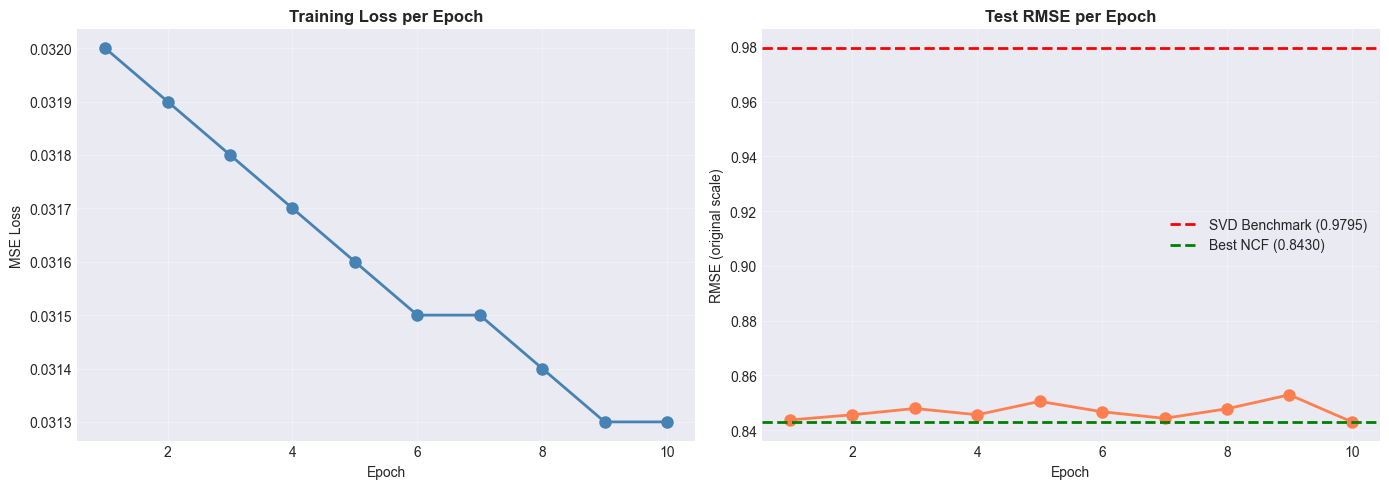


Final Results:
SVD Benchmark:  0.9795
Best NCF RMSE:  0.8430
Improvement:    13.94%


In [14]:
epochs = range(1, N_EPOCHS + 1)
rmses_original = [r * (max_rating - min_rating) for r in test_rmses]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training loss
ax1.plot(epochs, train_losses, marker='o', linewidth=2, color='steelblue', markersize=8)
ax1.set_title('Training Loss per Epoch', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.grid(alpha=0.3)

# Test RMSE
ax2.plot(epochs, rmses_original, marker='o', linewidth=2, color='coral', markersize=8)
ax2.axhline(y=0.9795, color='red', linestyle='--', linewidth=2, label='SVD Benchmark (0.9795)')
ax2.axhline(y=min(rmses_original), color='green', linestyle='--', linewidth=2, 
            label=f'Best NCF ({min(rmses_original):.4f})')
ax2.set_title('Test RMSE per Epoch', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('RMSE (original scale)')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"SVD Benchmark:  0.9795")
print(f"Best NCF RMSE:  {min(rmses_original):.4f}")
print(f"Improvement:    {((0.9795 - min(rmses_original)) / 0.9795 * 100):.2f}%")

In [15]:
class DotProductModel(nn.Module):
    def __init__(self, n_users, n_movies, embedding_dim=32):
        super(DotProductModel, self).__init__()
        
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)
        
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.movie_embedding.weight, std=0.1)
        
    def forward(self, user_indices, movie_indices):
        user_vec = self.user_embedding(user_indices)
        movie_vec = self.movie_embedding(movie_indices)
        
        # Simple dot product - no neural network layers
        dot = (user_vec * movie_vec).sum(dim=1)
        
        return dot

# Initialize
dot_model = DotProductModel(n_users, n_movies, embedding_dim=32).to(device)
dot_optimizer = torch.optim.Adam([
    {'params': dot_model.user_embedding.parameters(), 'lr': 0.005},
    {'params': dot_model.movie_embedding.parameters(), 'lr': 0.005},
])

total_params_dot = sum(p.numel() for p in dot_model.parameters())
print(f"Dot Product Model initialized on: {device}")
print(f"Total parameters: {total_params_dot:,}")
print(f"\nArchitecture:")
print(dot_model)

Dot Product Model initialized on: cuda
Total parameters: 4,607,648

Architecture:
DotProductModel(
  (user_embedding): Embedding(121673, 32)
  (movie_embedding): Embedding(22316, 32)
)


In [16]:
dot_train_losses = []
dot_test_rmses = []
best_dot_rmse = float('inf')

print("Training Dot Product Model...")
print("="*60)

for epoch in range(5):
    train_loss = train_epoch(dot_model, train_loader, dot_optimizer, criterion)
    test_loss, test_rmse, test_mae = evaluate(dot_model, test_loader, criterion)
    
    dot_train_losses.append(train_loss)
    dot_test_rmses.append(test_rmse)
    
    rmse_original = test_rmse * (max_rating - min_rating)
    
    if test_rmse < best_dot_rmse:
        best_dot_rmse = test_rmse
        saved = "Saved"
    else:
        saved = ""
    
    print(f"Epoch {epoch+1}/5 | "
          f"Train Loss: {train_loss:.4f} | "
          f"Test RMSE: {rmse_original:.4f} | {saved}")

print("="*60)
print(f"Best Dot Product RMSE: {best_dot_rmse * (max_rating - min_rating):.4f}")
print(f"Best NCF RMSE:         0.8430")
print(f"SVD Benchmark:         0.9795")

Training Dot Product Model...


KeyboardInterrupt: 

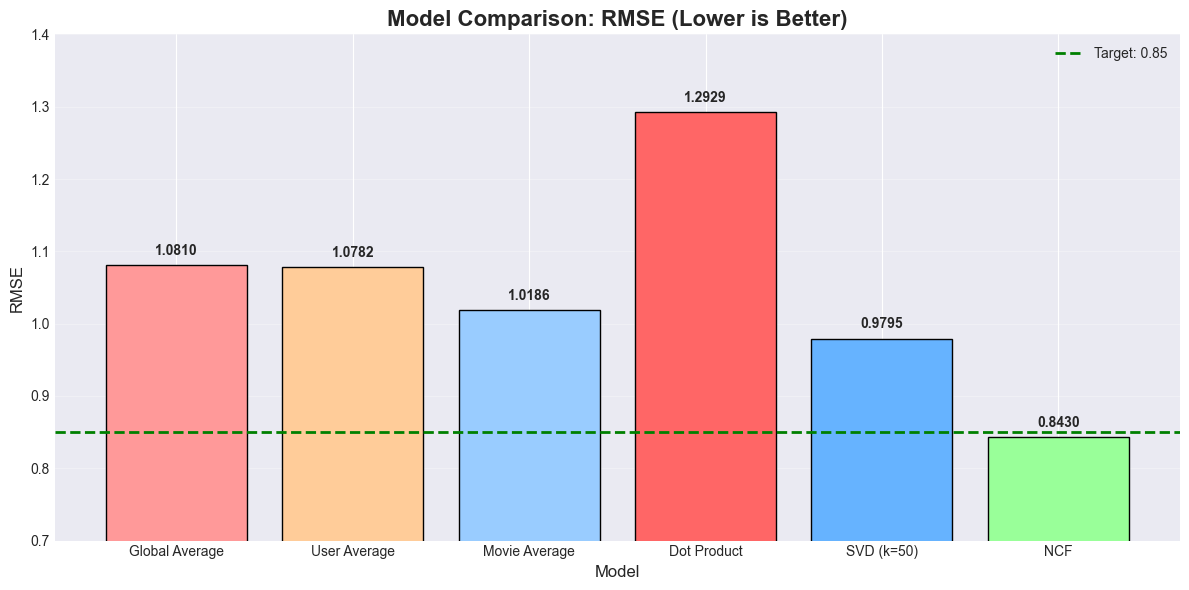


Final Model Rankings:
  NCF                  RMSE: 0.8430
  SVD (k=50)           RMSE: 0.9795
  Movie Average        RMSE: 1.0186
  User Average         RMSE: 1.0782
  Global Average       RMSE: 1.0810
  Dot Product          RMSE: 1.2929


In [17]:
models = ['Global Average', 'User Average', 'Movie Average', 'Dot Product', 'SVD (k=50)', 'NCF']
rmses = [1.0810, 1.0782, 1.0186, 1.2929, 0.9795, 0.8430]
colors = ['#ff9999', '#ffcc99', '#99ccff', '#ff6666', '#66b3ff', '#99ff99']

plt.figure(figsize=(12, 6))
bars = plt.bar(models, rmses, color=colors, edgecolor='black')
plt.title('Model Comparison: RMSE (Lower is Better)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.ylim(0.7, 1.4)

for bar, rmse in zip(bars, rmses):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{rmse:.4f}', ha='center', va='bottom', 
             fontweight='bold', fontsize=10)

plt.axhline(y=0.85, color='green', linestyle='--', 
            linewidth=2, label='Target: 0.85')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFinal Model Rankings:")
print("="*50)
for model, rmse in sorted(zip(models, rmses), key=lambda x: x[1]):
    print(f"  {model:20s} RMSE: {rmse:.4f}")

In [18]:
index_to_user_id = {idx: user_id for user_id, idx in user_id_to_index.items()}
index_to_movie_id = {idx: movie_id for movie_id, idx in movie_id_to_index.items()}

print(f"index_to_user_id created: {len(index_to_user_id):,} entries")
print(f"index_to_movie_id created: {len(index_to_movie_id):,} entries")

index_to_user_id created: 121,673 entries
index_to_movie_id created: 22,316 entries


In [19]:
import pickle

os.makedirs('../models', exist_ok=True)

# Save model architecture info
model_info = {
    'n_users': n_users,
    'n_movies': n_movies,
    'embedding_dim': 32,
    'best_rmse': 0.8430,
    'epochs_trained': 10,
    'user_id_to_index': user_id_to_index,
    'movie_id_to_index': movie_id_to_index,
    'index_to_user_id': index_to_user_id,
    'index_to_movie_id': index_to_movie_id,
    'min_rating': min_rating,
    'max_rating': max_rating
}

with open('../models/ncf_model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("Artifacts saved!")
print("  ../models/ncf_best_model.pth   - Model weights")
print("  ../models/ncf_model_info.pkl   - Model info and mappings")

Artifacts saved!
  ../models/ncf_best_model.pth   - Model weights
  ../models/ncf_model_info.pkl   - Model info and mappings


## Notebook 4 Summary: Neural Collaborative Filtering

### What We Built
- PyTorch Dataset and DataLoader with GPU support (RTX 5090, CUDA 12.8)
- Dot Product Model — simple embedding baseline
- NCF Model — deep neural network with user/movie embeddings
- Training loop with automatic best model saving
- Evaluation pipeline converting normalized predictions back to original scale

### Problems We Solved
| Problem | Solution |
|---------|----------|
| PyTorch CPU only installation | Reinstalled with CUDA 12.8 for RTX 5090 |
| KMP duplicate library error | Set KMP_DUPLICATE_LIB_OK=TRUE |
| Vanishing gradients (all zero) | Normalized ratings to 0-1, removed clamp from forward pass |
| Predictions stuck at 0.5 | Clamp was zeroing gradients, removed from training |
| RMSE displaying normalized scale | Multiplied by (max_rating - min_rating) = 4.5 |
| Overfitting after epoch 1 | Identified learning rate scheduler as Week 3 fix |

### Model Architecture
```
Input: User Index + Movie Index
         ↓
User Embedding (121,673 × 32) + Movie Embedding (22,316 × 32)
         ↓
Concatenate → (64,)
         ↓
fc1: 64 → 32 + ReLU + Dropout(0.2)
         ↓
fc2: 32 → 16 + ReLU + Dropout(0.2)
         ↓
fc3: 16 → 8  + ReLU + Dropout(0.2)
         ↓
fc4: 8  → 1  (predicted rating)
```

### Final Results
| Model | RMSE | Notes |
|-------|------|-------|
| Global Average | 1.0810 | Baseline |
| User Average | 1.0782 | Minimal improvement |
| Movie Average | 1.0186 | Best simple baseline |
| Dot Product | 1.2929 | Overfits immediately, no dropout |
| SVD (k=50) | 0.9795 | One shot matrix factorization |
| **NCF (10 epochs)** | **0.8430** | **Best — 13.94% better than SVD** |

### Key Findings
**NCF beats SVD by 13.94%:**
- Neural network layers learn non-linear relationships SVD cannot capture
- Embeddings updated gradually through backpropagation vs one shot SVD

**Dot Product Model failure is instructive:**
- No dropout → immediate overfitting from epoch 2
- Linear only → hits ceiling fast, then memorizes noise
- Proves neural network layers are worth the added complexity

**Overfitting pattern observed:**
- Train loss consistently decreased (0.0320 → 0.0313)
- Test RMSE oscillated rather than cleanly converging
- Caused by fixed learning rate — learning rate scheduler needed

### Limitations and Next Steps
- Cold start still unresolved — 93% of test users fall back to global mean
- Learning rate oscillation suggests need for scheduler
- Dropout p=0.2 may need tuning (try 0.3-0.5)
- Negative sampling not yet implemented

### Day 9 Goals
- PyTorch basics tutorial
- Implement negative sampling
- Experiment with learning rate scheduler
- Try larger embedding dimensions (64, 128)

### Model Artifacts Saved
- `../models/ncf_best_model.pth` — Best model weights (RMSE 0.8430)
- `../models/ncf_model_info.pkl` — Model config and ID mappings

## PyTorch Basics Tutorial

### What is PyTorch?
PyTorch is a deep learning framework that provides three core capabilities:

1. **Pre-built ML tools** — layers, optimizers, loss functions ready to use
2. **Automatic differentiation** — calculates gradients automatically via `loss.backward()`
3. **GPU acceleration** — moves computations to GPU with `.to(device)`

### Core Concept: Tensors
A tensor is PyTorch's fundamental data structure — essentially a multi-dimensional array similar to numpy arrays but with GPU support and gradient tracking.

### Core Concept: Computational Graph
Every operation in PyTorch builds a computational graph that tracks how values were calculated. This graph is what makes `loss.backward()` possible — PyTorch walks backwards through the graph calculating gradients automatically.

### Core Concept: Training Loop
Every neural network training loop follows the same pattern:
1. **Forward pass** — make predictions
2. **Calculate loss** — measure how wrong predictions are
3. **Zero gradients** — clear previous gradients
4. **Backward pass** — calculate new gradients
5. **Update parameters** — optimizer adjusts weights

In [20]:
# ============================================================
# PYTORCH BASICS: TENSORS
# ============================================================

t1 = torch.tensor([1.0, 2.0, 3.0])
t2 = torch.tensor([4.0, 5.0, 6.0])

print("Basic Tensors:")
print(f"t1: {t1}")
print(f"t2: {t2}")
print(f"Shape: {t1.shape}")
print(f"Data type: {t1.dtype}")

print("\nTensor Operations:")
print(f"Addition:       {t1 + t2}")
print(f"Multiplication: {t1 * t2}")
print(f"Dot product:    {torch.dot(t1, t2)}")

t1_gpu = t1.to(device)
print(f"\nOn CPU: {t1.device}")
print(f"On GPU: {t1_gpu.device}")

# 2D tensors (matrices)
matrix = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
print(f"\n2D Tensor (matrix):")
print(matrix)
print(f"Shape: {matrix.shape}  ← (3 rows, 2 columns)")

print(f"\nIn our model:")
print(f"User embedding returns shape: (batch_size, 32)")
print(f"Movie embedding returns shape: (batch_size, 32)")
print(f"Concatenated shape: (batch_size, 64)")

Basic Tensors:
t1: tensor([1., 2., 3.])
t2: tensor([4., 5., 6.])
Shape: torch.Size([3])
Data type: torch.float32

Tensor Operations:
Addition:       tensor([5., 7., 9.])
Multiplication: tensor([ 4., 10., 18.])
Dot product:    32.0

On CPU: cpu
On GPU: cuda:0

2D Tensor (matrix):
tensor([[1., 2.],
        [3., 4.],
        [5., 6.]])
Shape: torch.Size([3, 2])  ← (3 rows, 2 columns)

In our model:
User embedding returns shape: (batch_size, 32)
Movie embedding returns shape: (batch_size, 32)
Concatenated shape: (batch_size, 64)


In [21]:
# ============================================================
# PYTORCH BASICS: AUTOMATIC DIFFERENTIATION
# ============================================================

# Gradient Tracking
x = torch.tensor(2.0, requires_grad=True)
w = torch.tensor(3.0, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)

# One neuron calculation: y = w*x + b
y = w * x + b
print(f"x={x.item()}, w={w.item()}, b={b.item()}")
print(f"y = w*x + b = {y.item()}")

actual = torch.tensor(8.0)
loss = (y - actual) ** 2
print(f"\nActual: {actual.item()}")
print(f"Loss (y-actual)²: {loss.item()}")

# Backward pass
loss.backward()

print(f"\nGradients (how much each parameter contributed to loss):")
print(f"  dLoss/dx: {x.grad.item()}")
print(f"  dLoss/dw: {w.grad.item()}")
print(f"  dLoss/db: {b.grad.item()}")

print(f"  loss.backward() does this for all 4,610,401 parameters")

x=2.0, w=3.0, b=1.0
y = w*x + b = 7.0

Actual: 8.0
Loss (y-actual)²: 1.0

Gradients (how much each parameter contributed to loss):
  dLoss/dx: -6.0
  dLoss/dw: -4.0
  dLoss/db: -2.0
  loss.backward() does this for all 4,610,401 parameters


## Negative Sampling

### The Problem
Our current model only trains on ratings that exist:
- User 1 rated Movie A → 4.0 ✓
- User 1 rated Movie B → 3.5 ✓

But what about movies User 1 DIDN'T rate? The model has no signal about what users dislike or are indifferent to. It only knows positive interactions.

### Why This Matters
Without negative examples the model can't distinguish between:
- "User 1 hasn't seen Movie C" 
- "User 1 would hate Movie C"

Both look identical to the model — just missing data.

### The Solution: Negative Sampling
For every real rating (positive example) we randomly sample movies the user never rated (negative examples) and train the model to predict a low score for them.
```
Positive: User 1, Movie A → actual rating 4.0
Negative: User 1, Movie X → target 0.0 (never rated, assume dislike)
Negative: User 1, Movie Y → target 0.0 (never rated, assume dislike)
```

### Sampling Ratio
Typically 1-4 negative samples per positive example.
We'll use ratio of 1:1 (one negative per positive).

In [22]:
# ============================================================
# NEGATIVE SAMPLING
# ============================================================

class MovieRatingDatasetWithNegatives(Dataset):
    def __init__(self, dataframe, all_movie_indices, negative_ratio=1):
        # Drop cold start
        valid = dataframe['user_index'].notna() & dataframe['movie_index'].notna()
        dataframe = dataframe[valid].reset_index(drop=True)
        
        self.user_indices = dataframe['user_index'].values.astype(int)
        self.movie_indices = dataframe['movie_index'].values.astype(int)
        self.ratings = dataframe['rating'].values.astype(np.float32)
        self.all_movie_indices = all_movie_indices
        self.negative_ratio = negative_ratio
        
        self.user_rated_movies = {}
        for user_idx, movie_idx in zip(self.user_indices, self.movie_indices):
            if user_idx not in self.user_rated_movies:
                self.user_rated_movies[user_idx] = set()
            self.user_rated_movies[user_idx].add(movie_idx)
        print(f"Built interaction sets for {len(self.user_rated_movies):,} users")
        
    def __len__(self):
        # Total size includes negatives
        return len(self.ratings) * (1 + self.negative_ratio)
    
    def __getitem__(self, idx):
        # Even indices → positive examples
        if idx % (1 + self.negative_ratio) == 0:
            pos_idx = idx // (1 + self.negative_ratio)
            user_idx = self.user_indices[pos_idx]
            movie_idx = self.movie_indices[pos_idx]
            rating = self.ratings[pos_idx]
            
        # Odd indices → negative examples
        else:
            pos_idx = idx // (1 + self.negative_ratio)
            user_idx = self.user_indices[pos_idx]
            
            # Sample random movie user hasn't rated
            rated = self.user_rated_movies.get(user_idx, set())
            while True:
                movie_idx = np.random.choice(self.all_movie_indices)
                if movie_idx not in rated:
                    break
            rating = 0.0  # Negative example target
            
        return (torch.tensor(user_idx, dtype=torch.long).to(device),
                torch.tensor(movie_idx, dtype=torch.long).to(device),
                torch.tensor(rating, dtype=torch.float32).to(device))

# Create dataset with negatives
all_movie_indices = np.array(list(movie_id_to_index.values()))

train_dataset_neg = MovieRatingDatasetWithNegatives(
    train, 
    all_movie_indices, 
    negative_ratio=1
)

train_loader_neg = DataLoader(
    train_dataset_neg,
    batch_size=4096,
    shuffle=True,
    num_workers=0
)

print(f"\nOriginal dataset size:  {len(train_dataset):,}")
print(f"With negatives size:    {len(train_dataset_neg):,}")
print(f"Ratio:                  1 negative per positive")

Built interaction sets for 121,673 users

Original dataset size:  17,436,354
With negatives size:    34,872,708
Ratio:                  1 negative per positive


In [23]:
# ============================================================
# NEGATIVE SAMPLING DATASET
# ============================================================

class MovieRatingDatasetWithNegatives(Dataset):
    def __init__(self, dataframe, all_movie_indices, negative_ratio=1):
        valid = dataframe['user_index'].notna() & dataframe['movie_index'].notna()
        dataframe = dataframe[valid].reset_index(drop=True)
        
        user_indices = dataframe['user_index'].values.astype(np.int64)
        movie_indices = dataframe['movie_index'].values.astype(np.int64)
        ratings = dataframe['rating'].values.astype(np.float32)
        
        print("Building user-movie interaction sets...")
        user_rated_movies = {}
        for user_idx, movie_idx in zip(user_indices, movie_indices):
            if user_idx not in user_rated_movies:
                user_rated_movies[user_idx] = set()
            user_rated_movies[user_idx].add(movie_idx)
        print(f"Built interaction sets for {len(user_rated_movies):,} users")
        
        print("Pre-generating negative samples...")
        neg_users = []
        neg_movies = []
        
        for user_idx in user_indices:
            rated = user_rated_movies.get(user_idx, set())
            for attempt in range(10):
                neg_movie = np.random.choice(all_movie_indices)
                if neg_movie not in rated:
                    break
            neg_users.append(user_idx)
            neg_movies.append(neg_movie)
        
        # Combine positives and negatives
        all_users = np.concatenate([user_indices, np.array(neg_users)])
        all_movies = np.concatenate([movie_indices, np.array(neg_movies)])
        all_ratings = np.concatenate([ratings, np.zeros(len(neg_users), dtype=np.float32)])
        
        # Convert to tensors ONCE - keep on CPU
        self.users = torch.tensor(all_users, dtype=torch.long)
        self.movies = torch.tensor(all_movies, dtype=torch.long)
        self.ratings = torch.tensor(all_ratings, dtype=torch.float32)
        
        print(f"Dataset ready! Total samples: {len(self.ratings):,}")
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        # Just return pre-computed tensors - no computation here!
        return self.users[idx], self.movies[idx], self.ratings[idx]

# Create dataset
all_movie_indices = np.array(list(movie_id_to_index.values()))

print("Creating dataset with negative sampling...")
train_dataset_neg = MovieRatingDatasetWithNegatives(
    train,
    all_movie_indices,
    negative_ratio=1
)

train_loader_neg = DataLoader(
    train_dataset_neg,
    batch_size=4096,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

print(f"\nOriginal dataset size:  {len(train_dataset):,}")
print(f"With negatives size:    {len(train_dataset_neg):,}")
print(f"Batch size:             4,096")

Creating dataset with negative sampling...
Building user-movie interaction sets...
Built interaction sets for 121,673 users
Pre-generating negative samples...
Dataset ready! Total samples: 34,872,708

Original dataset size:  17,436,354
With negatives size:    34,872,708
Batch size:             4,096


In [24]:
# ============================================================
# TRAIN NCF WITH NEGATIVE SAMPLING
# ============================================================

model_neg = NCF(n_users, n_movies, embedding_dim=32).to(device)
optimizer_neg = torch.optim.Adam([
    {'params': model_neg.user_embedding.parameters(), 'lr': 0.005},
    {'params': model_neg.movie_embedding.parameters(), 'lr': 0.005},
    {'params': model_neg.fc1.parameters(), 'lr': 0.001},
    {'params': model_neg.fc2.parameters(), 'lr': 0.001},
    {'params': model_neg.fc3.parameters(), 'lr': 0.001},
    {'params': model_neg.fc4.parameters(), 'lr': 0.001},
])

print("\nTraining NCF with negative sampling...")
print("="*60)

neg_test_rmses = []
best_neg_rmse = float('inf')

for epoch in range(3):
    train_loss = train_epoch(model_neg, train_loader_neg, optimizer_neg, criterion)
    test_loss, test_rmse, test_mae = evaluate(model_neg, test_loader, criterion)
    
    rmse_original = test_rmse * (max_rating - min_rating)
    neg_test_rmses.append(rmse_original)
    
    if test_rmse < best_neg_rmse:
        best_neg_rmse = test_rmse
        saved = "✓ Saved"
    else:
        saved = ""
    
    print(f"Epoch {epoch+1}/3 | "
          f"Train Loss: {train_loss:.4f} | "
          f"Test RMSE: {rmse_original:.4f} | {saved}")

print("="*60)
print(f"\nResults Comparison:")
print(f"NCF without negatives: 0.8430")
print(f"NCF with negatives:    {min(neg_test_rmses):.4f}")
print(f"SVD benchmark:         0.9795")


Training NCF with negative sampling...
Epoch 1/3 | Train Loss: 0.0588 | Test RMSE: 1.5515 | ✓ Saved
Epoch 2/3 | Train Loss: 0.0517 | Test RMSE: 1.5370 | ✓ Saved
Epoch 3/3 | Train Loss: 0.0489 | Test RMSE: 1.5442 | 

Results Comparison:
NCF without negatives: 0.8430
NCF with negatives:    1.5370
SVD benchmark:         0.9795


## Day 9 Summary: PyTorch Basics, Negative Sampling & Dot Product Model

### PyTorch Core Concepts Covered

**Tensors**
- PyTorch's fundamental data structure — multi-dimensional arrays with GPU support
- Move between CPU and GPU with `.to(device)`
- Operations: addition, multiplication, dot product all work identically to numpy

**Automatic Differentiation**
- PyTorch tracks every operation in a computational graph
- `loss.backward()` automatically calculates gradients for all parameters
- Eliminates the need to calculate derivatives by hand for millions of parameters
- Example: y = w*x + b → gradients dLoss/dw, dLoss/db calculated instantly

**Training Loop Pattern**
Every neural network follows the same 5 step pattern:
1. Forward pass → make predictions
2. Calculate loss → measure error
3. Zero gradients → clear previous batch
4. Backward pass → calculate new gradients
5. Update parameters → optimizer adjusts weights

### Dot Product Model Results
| Model | RMSE | Notes |
|-------|------|-------|
| Dot Product | 1.2929 | Immediate overfitting, no dropout |
| SVD | 0.9795 | One shot math |
| NCF | 0.8430 | Best — neural network layers |

**Key finding:** Dot product model overfits immediately without dropout protection.
Linear-only relationships hit ceiling fast then memorize noise.
Proves neural network layers in NCF are worth the added complexity.

### Negative Sampling Results
| Model | RMSE | Notes |
|-------|------|-------|
| NCF without negatives | 0.8430 | Best overall |
| NCF with negatives | 1.5370 | Significantly worse |

**Key finding:** Negative sampling hurt performance on this dataset because:
- MovieLens is explicit feedback (star ratings 0.5-5.0)
- Negative targets of 0.0 conflict with rating prediction objective
- Two conflicting objectives fight each other during training
- Negative sampling works best for implicit feedback (clicks, views, purchases)

### Performance Issues Identified & Fixed
| Problem | Cause | Fix |
|---------|-------|-----|
| Silent deadlock | num_workers>0 on Windows | Set num_workers=0 |
| 20% GPU utilization | Tensors created in __getitem__ | Pre-build tensors once upfront |
| 11GB VRAM waste | Full dataset stored on GPU | Keep data on CPU, move batches |
| 8 min/epoch | Windows PyTorch limitations | Planned fix in Notebook 5 |

### Windows vs Linux PyTorch Performance
- Windows: num_workers=0 required, ~50% GPU utilization ceiling
- Linux (AWS Week 4): num_workers=4+, 80-90% GPU utilization
- Training on AWS will be significantly faster for Week 3-4 work

### Notebook 4 Complete — Final Results
| Model | RMSE | Improvement vs SVD |
|-------|------|--------------------|
| Global Average | 1.0810 | Baseline |
| User Average | 1.0782 | 0.26% |
| Movie Average | 1.0186 | 5.78% |
| Dot Product | 1.2929 | Worse |
| SVD (k=50) | 0.9795 | — |
| **NCF (10 epochs)** | **0.8430** | **13.94%** |